# Citi Bike Usage Over Time- An Analysis on Whether a Pandemic May Affect New York Bike Trips

#### Programmer: K. Bischoff
#### Date Created: 05/19/2020
#### Program Description:
#### Use CitiBike data to identify trends in Citi Bike trips in New York over the course of 1 year. Due to weather and an unprecedented pandemic, we are interested in noting if, and to what degree, bike riding trips have been affected. This SAS program is used to import CitiBike data from March 2019 through March 2020 (1 datafile per calendar month.) Additionally, an algorithm is developed to try to eliminate repeat bike riders in order to understand rider demographics through age and gender. 

#### This code uses Base SAS, SAS Macro, SAS STAT, and procedures such as the means and univariate procedures. SGPLOT is used for line/scatter plots and boxplots. Importing and exporting to Excel are demonstrated. Additionally, reporting of findings are refined by using proc report and ODS output. 

#### The end of the program prepares data to be output to Excel for use in Tableau

In [1]:
/*Comment out if the log results need to be viewed.*/
/*The code, log, and results have been reviewed. In the case of saving room and for ease of following along for presentation in Github,
the log has been suppressed. Otherwise the log always shows.*/

options nosource nonotes;

SAS Connection established. Subprocess id is 2611



In [2]:
*Set up*;
*Use macros for conditional processing*;

%let last=2019;
%let now=2020;

In [5]:
 %macro imp_ort_in ();
 
 %do i=3 %to 12;
 proc import datafile="/folders/myfolders/JC&last.&i._citibike_tripdata.csv"
        out=citi_&last.&i.
        dbms=csv
        replace;
     getnames=yes;
     OPTION VALIDVARNAME=V7;
run;
%end;

%do j=1 %to 3;
 proc import datafile="/folders/myfolders/JC&now.&j._citibike_tripdata.csv"
        out=citi_&now.&j.
        dbms=csv
        replace;
     getnames=yes;
     OPTION VALIDVARNAME=V7;
run;
%end;


%mend imp_ort_in;
%imp_ort_in;


In [6]:
/*Print a few data sets for checking*/ /*Comment out if no longer testing*/

/* proc print data=citi_20201 (obs=5);
run; */

In [7]:
/* proc print data=citi_201912 (obs=5);
run; */

In [8]:
/* proc print data=citi_20194 (obs=5);
run; */

## Identify Overall Trend in the Number of Trips over the Course of a Year
### Will the number of trips decrease due to the introduction of the pandemic?
### Are there seasonal patterns?

## First Analysis
### Identify how many bike trips were made for each month and visualize the trend
### Loop through each dataset for a count of total number of records

In [9]:
%macro loop_count ();

%do i=3 %to 12;

    data citi1_2019&i.;
    set citi_2019&i.;
    k +1;
    output;
    run;

    data citi2_2019&i. (keep=k i year rename=(i=month));
    set citi1_2019&i. end=last;
    year=2019;
    i="&i.";
    if last;
    run;
    
    data citi3_2019&i.;
    set citi2_2019&i.;
    month1=input(month,8.);
    drop month;
    rename month1=month;
    run;

%end;

%do i=1 %to 3;

    data citi1_2020&i.;
    set citi_2020&i.;
    k +1;
    output;
    run;

    data citi2_2020&i. (keep=k i year rename=(i=month));
    set citi1_2020&i. end=last;
    year=2020;
    i="&i.";
    if last;
    run;
    
    data citi3_2020&i.;
    set citi2_2020&i.;
    month1=input(month,8.);
    drop month;
    rename month1=month;
    run;

%end;

%mend loop_count;
%loop_count;

In [10]:
/*Test Print*/
proc print data=citi3_20202;
run;

Obs,k,year,month
1,22962,2020,2


In [11]:
/*Stack data- for plotting and viewing a general trend over time*/
/*Want to identify and peaks or drops in the number of Citi Bike trips*/

data stacked_months (rename=k=trip_total);
set citi3_20193 citi3_20194 citi3_20195 citi3_20196 citi3_20197 citi3_20198 citi3_20199
    citi3_201910 citi3_201911 citi3_201912 citi3_20201 citi3_20202 citi3_20203;
run;


In [12]:
/*Test Print*/
proc print data=stacked_months;
run;

Obs,trip_total,year,month
1,23606,2019,3
2,33056,2019,4
3,36135,2019,5
4,39430,2019,6
5,43746,2019,7
6,48711,2019,8
7,49244,2019,9
8,42253,2019,10
9,30797,2019,11
10,19728,2019,12


In [13]:
/*Prep for month titles*/

data stacked_months1 (rename=monthk=month);
set stacked_months;
if month = 1 then monthk = 'Jan';
if month = 2 then monthk = 'Feb';
if month = 3 then monthk = 'Mar';
if month = 4 then monthk = 'Apr';
if month = 5 then monthk = 'May';
if month = 6 then monthk = 'Jun';
if month = 7 then monthk = 'Jul';
if month = 8 then monthk = 'Aug';
if month = 9 then monthk = 'Sep';
if month = 10 then monthk = 'Oct';
if month = 11 then monthk = 'Nov';
if month = 12 then monthk = 'Dec';
drop month;
run;

In [14]:
/*Test Print*/
proc print data=stacked_months1;
run;

Obs,trip_total,year,month
1,23606,2019,Mar
2,33056,2019,Apr
3,36135,2019,May
4,39430,2019,Jun
5,43746,2019,Jul
6,48711,2019,Aug
7,49244,2019,Sep
8,42253,2019,Oct
9,30797,2019,Nov
10,19728,2019,Dec


In [15]:
/*Concatenate Months for X-axis in plotting over time*/

data stacked_months2;
set stacked_months1;
date = catx('_',month,year);
run;

In [16]:
/*Test Print*/
proc print data=stacked_months2;
run;

Obs,trip_total,year,month,date
1,23606,2019,Mar,Mar_2019
2,33056,2019,Apr,Apr_2019
3,36135,2019,May,May_2019
4,39430,2019,Jun,Jun_2019
5,43746,2019,Jul,Jul_2019
6,48711,2019,Aug,Aug_2019
7,49244,2019,Sep,Sep_2019
8,42253,2019,Oct,Oct_2019
9,30797,2019,Nov,Nov_2019
10,19728,2019,Dec,Dec_2019


## Plot the Overall Number of Citi Bike Trips Over 1 year


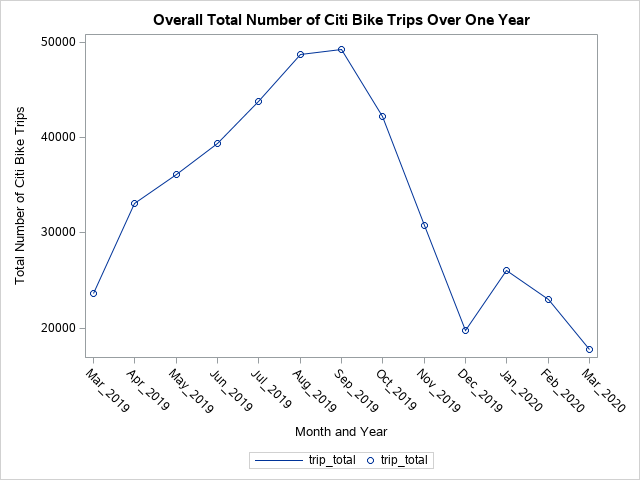

In [17]:
proc sgplot data=stacked_months2; 
title 'Overall Total Number of Citi Bike Trips Over One Year';
series x=date y=trip_total;
scatter x=date y=trip_total;
xaxis label = "Month and Year";
yaxis label = "Total Number of Citi Bike Trips";
run;
title;

#### The pattern seen in the plot illustrates that the number of bike trips increases over spring and summer.
#### The peak in number of bike trips, based on this plot over the last year, was in October 2019. After October 2019, the bike trips decreased. While there was a slight increase in bike trips from December 2019 to January 2020, the number of bike trips declined. The plot also shows that the bike trips in March 2020 were less vs. the number of bike trips in March 2019 (17,719 bike trips vs. 23,606 bike trips.)

## Now, identify if there is a pattern when stratified by age or gender
### Age plays a role in risk during a pandemic- are older populations taking less Citi Bike trips?
### Is there a pattern with gender?

## Age stratification first

In [18]:
/*Need to calculate age for each of the months of data*/
/*don't use sum here since missing needs to stay missing*/
    
%macro age_calc ();

%do i=3 %to 12;
    data citi_age_2019&i.;
    set citi_2019&i.;
    age = 2019 - birth_year;
    run;
%end;

%do i=1 %to 3;
    data citi_age_2020&i.;
    set citi_2020&i.;
    age = 2020 - birth_year;
    run;
%end;

%mend age_calc;
%age_calc;

In [19]:
/*Test Print*/ /*Comment out if not testing*/
/* proc print data=citi_age_20201 (obs=5);
run; */

#### Check distribution on a couple of month/year data sets

In [20]:
*Check distribution*;
proc univariate data=citi_age_201910;
var age;
run;

In [21]:
*Check distribution*;
proc univariate data=citi_age_20201;
var age;
run;

##### Age of 132 might not be realistic, but this is an estimate based on the current year.
##### In general, the age distribution seems reasonable to keep, and there are no missing values for these months and years.

In [22]:
*Create the age bins*;

%macro age_bins ();

%do i=3 %to 12;
    data citi_agebin_2019&i.;
    set citi_age_2019&i.;
    age_bin =.;
    age18_24=0;
    age25_34=0;
    age35_44=0;
    age45_54=0;
    age55_64=0;
    age65plus=0;
    if age ge 18 and age lt 25 then age18_24=1;
    if age ge 25 and age lt 35 then age25_34=1;
    if age ge 35 and age lt 45 then age35_44=1;
    if age ge 45 and age lt 55 then age45_54=1;
    if age ge 55 and age lt 65 then age55_64=1;
    if age ge 65 then age65plus=1;
    if age ge 18 and age lt 25 then age_bin=1;
    if age ge 25 and age lt 35 then age_bin=2;
    if age ge 35 and age lt 45 then age_bin=3;
    if age ge 45 and age lt 55 then age_bin=4;
    if age ge 55 and age lt 65 then age_bin=5;
    if age ge 65 then age_bin=6;
    
    k=1;
    run;
%end;

%do i=1 %to 3;
    data citi_agebin_2020&i.;
    set citi_age_2020&i.;
    age_bin =.;
    age18_24=0;
    age25_34=0;
    age35_44=0;
    age45_54=0;
    age55_64=0;
    age65plus=0;
    if age ge 18 and age lt 25 then age18_24=1;
    if age ge 25 and age lt 35 then age25_34=1;
    if age ge 35 and age lt 45 then age35_44=1;
    if age ge 45 and age lt 55 then age45_54=1;
    if age ge 55 and age lt 65 then age55_64=1;
    if age ge 65 then age65plus=1;
    if age ge 18 and age lt 25 then age_bin=1;
    if age ge 25 and age lt 35 then age_bin=2;
    if age ge 35 and age lt 45 then age_bin=3;
    if age ge 45 and age lt 55 then age_bin=4;
    if age ge 55 and age lt 65 then age_bin=5;
    if age ge 65 then age_bin=6;
    
    k=1;
    run;
%end;

%mend age_bins;
%age_bins;

In [23]:
/*Test Print*/ /*Comment out if not testing any longer*/
/* proc print data=citi_agebin_20203 (obs=5);
run; */

In [24]:
/*Sum the total for number of trips by age category*/

%macro age_bin_mean ();

%do i=3 %to 12;

proc means data=citi_agebin_2019&i. noprint;
var age18_24 age25_34 age35_44 age45_54 age55_64 age65plus;
output out=citi_agebin1_2019&i.
sum=age18_24 age25_34 age35_44 age45_54 age55_64 age65plus;
run;

data citi_agebin2_2019&i.;
set citi_agebin1_2019&i. (drop=_TYPE_ _FREQ_);
month=&i.;
year=2019;
run;

%end;

%do i=1 %to 3;

proc means data=citi_agebin_2020&i. noprint;
var age18_24 age25_34 age35_44 age45_54 age55_64 age65plus;
output out=citi_agebin1_2020&i.
sum=age18_24 age25_34 age35_44 age45_54 age55_64 age65plus;
run;


data citi_agebin2_2020&i.;
set citi_agebin1_2020&i. (drop=_TYPE_ _FREQ_);
month=&i.;
year=2020;
run;


%end;


%mend age_bin_mean;
%age_bin_mean;

In [25]:
/*Test Print*//*Comment out if no longer testing*/
/* proc print data=citi_agebin1_20203;
run; */

In [26]:
/*Test Print*//*Comment out if no longer testing*/
/* proc print data=citi_agebin2_20203;
run; */

In [27]:
/*Stack age datasets*/

data stacked_months_age;
set citi_agebin2_20193 citi_agebin2_20194 citi_agebin2_20195 citi_agebin2_20196 citi_agebin2_20197 citi_agebin2_20198
citi_agebin2_20199 citi_agebin2_201910 citi_agebin2_201911 citi_agebin2_201912 citi_agebin2_20201 citi_agebin2_20202
citi_agebin2_20203;
run;

In [28]:
/*Test Print*//*Comment out if no longer testing*/
/* proc print data=stacked_months_age;
run; */

In [29]:
/*Prep for month titles*/

data stacked_months_age1 (rename=monthk=month);
set stacked_months_age;
if month = 1 then monthk = 'Jan';
if month = 2 then monthk = 'Feb';
if month = 3 then monthk = 'Mar';
if month = 4 then monthk = 'Apr';
if month = 5 then monthk = 'May';
if month = 6 then monthk = 'Jun';
if month = 7 then monthk = 'Jul';
if month = 8 then monthk = 'Aug';
if month = 9 then monthk = 'Sep';
if month = 10 then monthk = 'Oct';
if month = 11 then monthk = 'Nov';
if month = 12 then monthk = 'Dec';
drop month;
run;

In [30]:
/*Concatenate Months for X-axis in plotting over time*/

data stacked_months_age2;
set stacked_months_age1;
date = catx('_',month,year);
run;

In [31]:
/*Test Print*//*Comment out if no longer testing*/
/* proc print data=stacked_months_age2;
run; */

In [32]:
/*Sum the total for number of trips by age category*/

%macro age_bin_mean_var ();

%do i=3 %to 12;

proc sort data=citi_agebin_2019&i. out=citi_agevar1_2019&i.;
by age;
run;

proc means data=citi_agevar1_2019&i. noprint;
var k;
output out=citi_agevar2_2019&i.
sum=age;
by age_bin;
run;

data citi_agevar3_2019&i.;
set citi_agevar2_2019&i. (drop=_TYPE_ _FREQ_);
month=&i.;
year=2019;
run;

%end;

%do i=1 %to 3;

proc sort data=citi_agebin_2020&i. out=citi_agevar1_2020&i.;
by age;
run;

proc means data=citi_agevar1_2020&i. noprint;
var k;
output out=citi_agevar2_2020&i.
sum=age;
by age_bin;
run;


data citi_agevar3_2020&i.;
set citi_agevar2_2020&i. (drop=_TYPE_ _FREQ_);
month=&i.;
year=2020;
run;


%end;


%mend age_bin_mean_var;
%age_bin_mean_var;

In [33]:
/*Test Print*//*Comment out if no longer testing*/
/* proc print data=citi_agevar2_20203;
run; */

In [34]:
/*Test Print*//*Comment out if no longer testing*/
/* proc print data=citi_agevar3_20203;
run; */

In [35]:
/*Stack age datasets for the categorical age variable*/

data stacked_months_age_cat;
set citi_agevar3_20193 citi_agevar3_20194 citi_agevar3_20195 citi_agevar3_20196 citi_agevar3_20197 citi_agevar3_20198
citi_agevar3_20199 citi_agevar3_201910 citi_agevar3_201911 citi_agevar3_201912 citi_agevar3_20201 citi_agevar3_20202
citi_agevar3_20203;
run;

In [36]:
data stacked_months_age_cat1 (rename=(age=trip_total month=month1 age_l=age));
set stacked_months_age_cat;
/*Prep for month titles*/
if month = 1 then monthk = 'Jan';
if month = 2 then monthk = 'Feb';
if month = 3 then monthk = 'Mar';
if month = 4 then monthk = 'Apr';
if month = 5 then monthk = 'May';
if month = 6 then monthk = 'Jun';
if month = 7 then monthk = 'Jul';
if month = 8 then monthk = 'Aug';
if month = 9 then monthk = 'Sep';
if month = 10 then monthk = 'Oct';
if month = 11 then monthk = 'Nov';
if month = 12 then monthk = 'Dec';
date = catx('_',monthk,year);

if age_bin eq . then delete;

/*get age category labels for better context*/

if age_bin=1 then age_l = 'age18_24';
if age_bin=2 then age_l = 'age25_34';
if age_bin=3 then age_l = 'age35_44';
if age_bin=4 then age_l = 'age45_54';
if age_bin=5 then age_l = 'age55_64';
if age_bin=6 then age_l = 'age65_+';

run;

In [35]:
/*Test Print*//*Comment out if no longer testing*/
/* proc print data=stacked_months_age_cat1 (obs=20);
run; */

## Plot the Overall Number of Citi Bike Trips Over 1 year by Age Group


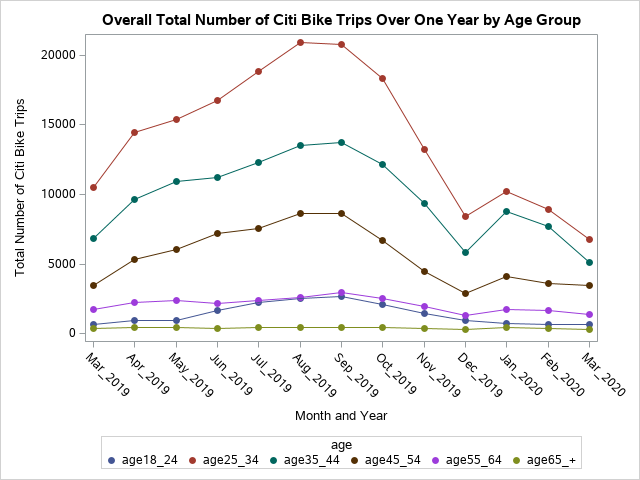

In [38]:
proc sgplot data=stacked_months_age_cat1; 
title 'Overall Total Number of Citi Bike Trips Over One Year by Age Group';
   scatter x=date y=trip_total / group=age
       markerattrs=(symbol=circlefilled) name="scat";
   series x=date y=trip_total / group=age_bin;     
xaxis label = "Month and Year";
yaxis label = "Total Number of Citi Bike Trips";
run;              


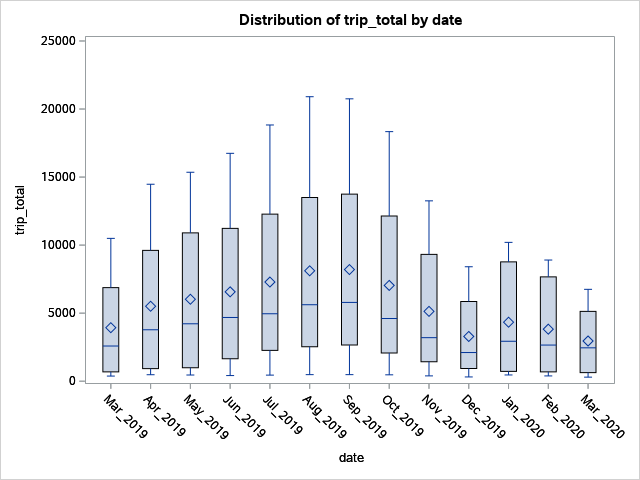

In [39]:
title;
options nogstyle;
title 'Distribution of Trip Total by Date';
proc boxplot data=stacked_months_age_cat1;
   plot trip_total*date / cframe= vligb
                     cboxes   = dagr
                     cboxfill = ywh;  
run;
title;


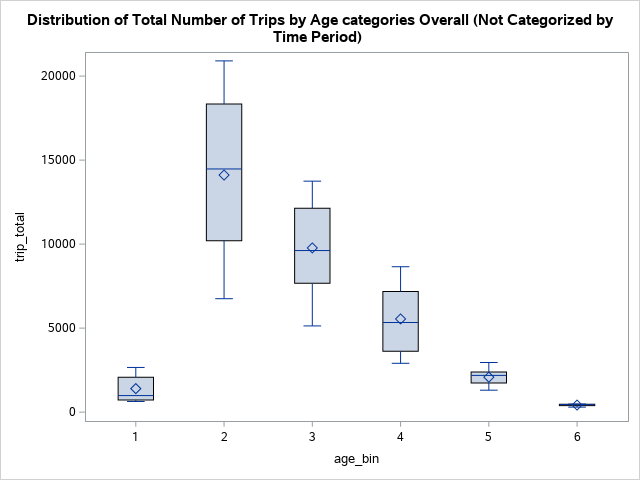

In [40]:
title;
title 'Distribution of Total Number of Trips by Age categories Overall (Not Categorized by Time Period)';
proc sgplot data=stacked_months_age_cat1;
vbox trip_total / category=age_bin;
run;

### Specifically look at age categories from age 45 and up

In [41]:
data stacked_months_age_cat2;
set stacked_months_age_cat1;
if age_bin in (4, 5, 6);
run;


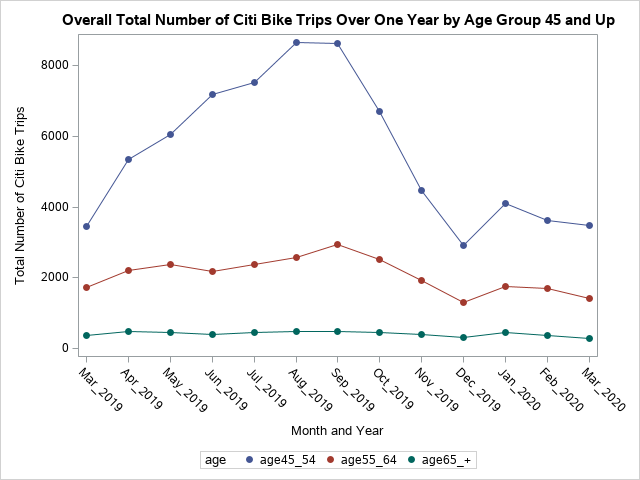

In [42]:
title;
proc sgplot data=stacked_months_age_cat2; 
title 'Overall Total Number of Citi Bike Trips Over One Year by Age Group 45 and Up';
   scatter x=date y=trip_total / group=age
       markerattrs=(symbol=circlefilled) name="scat";
   series x=date y=trip_total / group=age_bin;     
xaxis label = "Month and Year";
yaxis label = "Total Number of Citi Bike Trips";
run;   

### Challenging to see a pattern since each category is relative to the scale on the plot for all age categories
### Plot Age 65 and Up and see if a pattern is more clear

In [43]:
/*Age 65 and up*/
data stacked_months_age_cat3;
set stacked_months_age_cat1;
if age_bin in (6);
run;


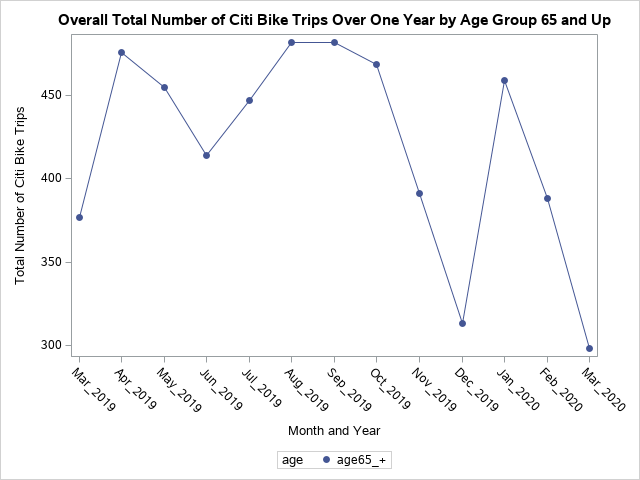

In [44]:
title;
proc sgplot data=stacked_months_age_cat3; 
title 'Overall Total Number of Citi Bike Trips Over One Year by Age Group 65 and Up';
   scatter x=date y=trip_total / group=age
       markerattrs=(symbol=circlefilled) name="scat";
   series x=date y=trip_total / group=age_bin;     
xaxis label = "Month and Year";
yaxis label = "Total Number of Citi Bike Trips";
run;   

### A pattern is clearly seen with the age 65 and older population that bike trips were less in March 2020 vs. december 2019. In earlier plots, this age category looked like a flat line with no trend.

### Overall, a similar pattern is seen across all age cateogries.

**********************************************************************************************************************************************************

*************************************************************************************************************

## Analyze by Gender

In [45]:
/*Stack age datasets for gender and keep data that's needed*/

data stacked_months_age_gender;
set citi_agebin_20193 citi_agebin_20194 citi_agebin_20195 citi_agebin_20196 citi_agebin_20197 citi_agebin_20198
citi_agebin_20199 citi_agebin_201910 citi_agebin_201911 citi_agebin_201912 citi_agebin_20201 citi_agebin_20202
citi_agebin_20203;
run;

In [46]:
title;
proc print data=stacked_months_age_gender (obs=5);
run;

Obs,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,age,age_bin,age18_24,age25_34,age35_44,age45_54,age55_64,age65plus,k
1,306,2019-03-01 06:47:08.2110,2019-03-01 06:52:14.7150,3183,Exchange Place,40.7162469,-74.0334588,3267,Morris Canal,40.712418824,-74.03852552,26272,Subscriber,1989,1,30,2,0,1,0,0,0,0,1
2,123,2019-03-01 07:30:53.0220,2019-03-01 07:32:56.7770,3183,Exchange Place,40.7162469,-74.0334588,3184,Paulus Hook,40.7141454,-74.0335519,26192,Subscriber,1966,1,53,4,0,0,0,1,0,0,1
3,328,2019-03-01 08:18:30.4030,2019-03-01 08:23:59.0590,3183,Exchange Place,40.7162469,-74.0334588,3213,Van Vorst Park,40.71848892,-74.04772663,26226,Subscriber,1971,2,48,4,0,0,0,1,0,0,1
4,95,2019-03-01 11:04:47.2020,2019-03-01 11:06:22.8130,3183,Exchange Place,40.7162469,-74.0334588,3184,Paulus Hook,40.7141454,-74.0335519,26204,Subscriber,1985,1,34,2,0,1,0,0,0,0,1
5,169,2019-03-01 11:51:29.4170,2019-03-01 11:54:19.2120,3183,Exchange Place,40.7162469,-74.0334588,3639,Harborside,40.7192517,-74.034234,29449,Subscriber,1971,1,48,4,0,0,0,1,0,0,1


In [47]:
/* proc contents data=stacked_months_age_gender;
run; */

In [48]:
/*Start time and End time are defined as character*/
/*Use a different method for creating date variable since data is already stacked*/

data stacked_months_age_gender1;
set stacked_months_age_gender;

month = substr(starttime,6, 2);
year = substr(starttime, 1, 4);

if month = '01' then monthk = 'Jan';
if month = '02' then monthk = 'Feb';
if month = '03' then monthk = 'Mar';
if month = '04' then monthk = 'Apr';
if month = '05' then monthk = 'May';
if month = '06' then monthk = 'Jun';
if month = '07' then monthk = 'Jul';
if month = '08' then monthk = 'Aug';
if month = '09' then monthk = 'Sep';
if month = '10' then monthk = 'Oct';
if month = '11' then monthk = 'Nov';
if month = '12' then monthk = 'Dec';

date = catx('_',monthk,year);

run;

In [49]:
/*Test Print*//*Comment out if no longer testing*/
/* proc print data=stacked_months_age_gender1 (obs=5);
run; */

In [50]:
/*Total number of trips per time period*/
proc sort data=stacked_months_age_gender1 out=stacked_months_age_gender2;
by date gender;
run;

In [51]:
proc means data=stacked_months_age_gender2 noprint;
var k;
output out=trip_gender 
sum = trip_total;
by date gender;
run;

In [52]:
data trip_gender1 (rename=gender1=gender);
set trip_gender;

if gender=0 then gender1='Unknown';
if gender=1 then gender1='Male';
if gender=2 then gender1='Female';

drop gender _TYPE_ _FREQ_;

run;


In [53]:
/*Test Print*//*Comment out if no longer testing*/
/* proc print data=trip_gender1 (obs=5);
run; */

In [54]:
/*Need to re-sort data*/
/*Bring back the numerical dates split by month and year*/
/*Otherwise- SAS will go in alphabetical order*/

data trip_gender2;
set trip_gender1;
mon = substr(date, 1, 3);
yr = substr(date, 5, 4);

if mon = 'Jan' then monthk = 1;
if mon = 'Feb' then monthk = 2;
if mon = 'Mar' then monthk = 3;
if mon = 'Apr' then monthk = 4;
if mon = 'May' then monthk = 5;
if mon = 'Jun' then monthk = 6;
if mon = 'Jul' then monthk = 7;
if mon = 'Aug' then monthk = 8;
if mon = 'Sep' then monthk = 9;
if mon = 'Oct' then monthk = 10;
if mon = 'Nov' then monthk = 11;
if mon = 'Dec' then monthk = 12;

run;


In [55]:
proc sort data=trip_gender2 out=trip_gender3;
by yr monthk;
run;


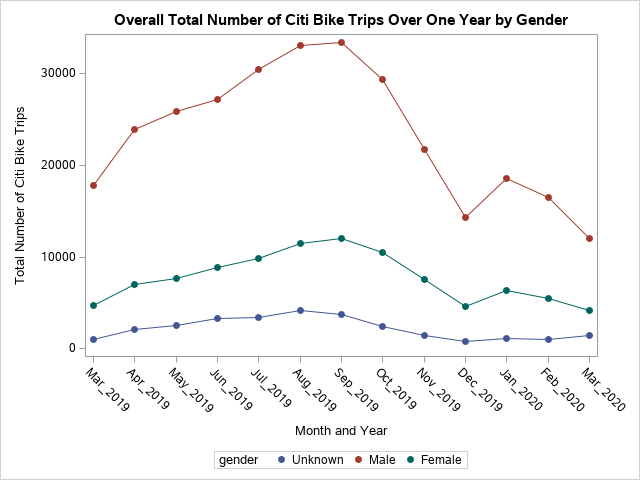

In [56]:
title;
proc sgplot data=trip_gender3; 
title 'Overall Total Number of Citi Bike Trips Over One Year by Gender';
   scatter x=date y=trip_total / group=gender
       markerattrs=(symbol=circlefilled) name="scat";
   series x=date y=trip_total / group=gender;     
xaxis label = "Month and Year";
yaxis label = "Total Number of Citi Bike Trips";
run;   


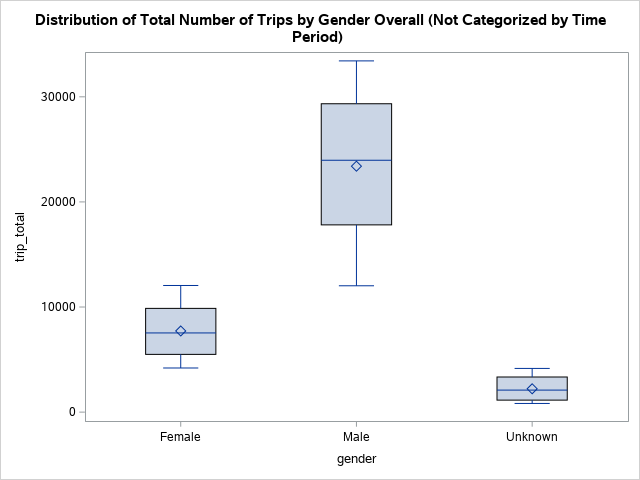

In [57]:
title;
title 'Distribution of Total Number of Trips by Gender Overall (Not Categorized by Time Period)';
proc sgplot data=trip_gender3;
vbox trip_total / category=gender;
run;

## Report Preparation
### Summarize findings in a PDF using Proc Report and graphs

In [58]:
proc sort data=stacked_months_age_cat1 out=trip_age;
by age_bin;
run;

proc transpose data=trip_age out= trip_age_wide (drop= _NAME_);
by age_bin;
id date;
var trip_total;
run;

In [59]:
proc sort data=stacked_months_age_gender1 out=trip_age1;
by date;
run;

In [60]:

title 'Counts and frequencies of Total Number of Citi Bike Trips by Age Cateogry Over 1 Year';
proc freq data=trip_age1;
tables k*age_bin/out = agefreq nopercent nocol;
by date;
where age_bin ne .;
run;
title;

In [61]:
proc print data=agefreq;
run;

Obs,date,k,age_bin,COUNT,PERCENT
1,Apr_2019,1,1,922,2.7900
2,Apr_2019,1,2,14473,43.7952
3,Apr_2019,1,3,9617,29.1010
4,Apr_2019,1,4,5334,16.1406
5,Apr_2019,1,5,2225,6.7328
6,Apr_2019,1,6,476,1.4404
7,Aug_2019,1,1,2534,5.2077
8,Aug_2019,1,2,20905,42.9622
9,Aug_2019,1,3,13499,27.7420
10,Aug_2019,1,4,8654,17.7850


In [62]:
proc print data=trip_age_wide (obs=5)

In [63]:
proc print data=stacked_months_age_cat1 (obs=5);
run;

## Prep data for Tableau visualizations

In [64]:
title;
proc print data=citi_agebin_20203 (obs=5);
run;

Obs,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,age,age_bin,age18_24,age25_34,age35_44,age45_54,age55_64,age65plus,k
1,389,2020-03-01 00:14:07.0000,2020-03-01 00:20:36.0880,3202,Newport PATH,40.7272235,-74.0337589,3203,Hamilton Park,40.727595966,-74.04424731,42381,Subscriber,1992,1,28,2,0,1,0,0,0,0,1
2,242,2020-03-01 00:48:06.4390,2020-03-01 00:52:08.9870,3185,City Hall,40.7177325,-74.043845,3205,JC Medical Center,40.716539781,-74.04963791,42155,Subscriber,1991,1,29,2,0,1,0,0,0,0,1
3,124,2020-03-01 01:08:46.4880,2020-03-01 01:10:51.2780,3272,Jersey & 3rd,40.723331586,-74.04595256,3278,Monmouth and 6th,40.725685484,-74.04879034,42376,Subscriber,1987,0,33,2,0,1,0,0,0,0,1
4,104,2020-03-01 01:22:35.4790,2020-03-01 01:24:20.2470,3202,Newport PATH,40.7272235,-74.0337589,3638,Washington St,40.7242941,-74.0354826,42350,Subscriber,1993,1,27,2,0,1,0,0,0,0,1
5,228,2020-03-01 01:39:20.2680,2020-03-01 01:43:09.1380,3194,McGinley Square,40.725339925,-74.06762213,3280,Astor Place,40.719282201,-74.07126188,42235,Subscriber,1988,1,32,2,0,1,0,0,0,0,1


In [65]:
proc print data=citi_agebin_20193 (obs=5);
run;

Obs,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,age,age_bin,age18_24,age25_34,age35_44,age45_54,age55_64,age65plus,k
1,306,2019-03-01 06:47:08.2110,2019-03-01 06:52:14.7150,3183,Exchange Place,40.7162469,-74.0334588,3267,Morris Canal,40.712418824,-74.03852552,26272,Subscriber,1989,1,30,2,0,1,0,0,0,0,1
2,123,2019-03-01 07:30:53.0220,2019-03-01 07:32:56.7770,3183,Exchange Place,40.7162469,-74.0334588,3184,Paulus Hook,40.7141454,-74.0335519,26192,Subscriber,1966,1,53,4,0,0,0,1,0,0,1
3,328,2019-03-01 08:18:30.4030,2019-03-01 08:23:59.0590,3183,Exchange Place,40.7162469,-74.0334588,3213,Van Vorst Park,40.71848892,-74.04772663,26226,Subscriber,1971,2,48,4,0,0,0,1,0,0,1
4,95,2019-03-01 11:04:47.2020,2019-03-01 11:06:22.8130,3183,Exchange Place,40.7162469,-74.0334588,3184,Paulus Hook,40.7141454,-74.0335519,26204,Subscriber,1985,1,34,2,0,1,0,0,0,0,1
5,169,2019-03-01 11:51:29.4170,2019-03-01 11:54:19.2120,3183,Exchange Place,40.7162469,-74.0334588,3639,Harborside,40.7192517,-74.034234,29449,Subscriber,1971,1,48,4,0,0,0,1,0,0,1


### We have trip duration, so we do not need the full start time and stop time for this analysis

In [66]:
data citi_agebin_march2020;
set citi_agebin_20203;
drop starttime stoptime k;
date='Mar_2020';
run;

data citi_agebin_march2019;
set citi_agebin_20193;
drop starttime stoptime k;
date='Mar_2019';
run;

In [67]:
/* proc export data=work.citi_agebin_march2019
outfile='/folders/myfolders/citibikemarch2019.csv'
dbms=csv
replace;
run; */